In [11]:
"""
Modified LSTM to work on a bigger multiclass extract and tuned it a bit.

This is the final LSTM model we ended up using.

Author: Wesley
"""
import numpy as np
import pandas as pd
import seaborn as sns
import statistics as stats
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import io # StringIO
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.metrics import classification_report

In [12]:
multiclass = pd.read_csv("multiclass_big.csv")

In [13]:
# Encode attack labels to int and save as array to be used later.
le = LabelEncoder()
multiclass[" Label"] = le.fit_transform(multiclass[" Label"].values)

multiclass_labels = []
print("\nMulticlass Label Encodings (in order of digits 0 -> n): ")
for i in range(0, len(list(set(list(multiclass[' Label']))))):
    multiclass_labels.append(le.inverse_transform([i])[0])

print(multiclass_labels)


Multiclass Label Encodings (in order of digits 0 -> n): 
['DNS', 'LDAP', 'MSSQL', 'NTP', 'NetBIOS', 'SNMP', 'SSDP', 'Syn', 'TFTP', 'UDP', 'UDP-lag']


In [14]:
y = multiclass[" Label"].copy()
X = multiclass.drop([" Label"], axis=1)

In [15]:
X_train0, X_test, y_train0, y_test = train_test_split(X, y, test_size = 0.25, stratify=y, random_state=42)
scal = StandardScaler()
scal = scal.fit(X_train0)
X_test = scal.transform(X_test)
X_train, X_val, y_train, y_val = train_test_split(X_train0, y_train0, test_size = 0.125, stratify=y_train0, random_state=42)
X_train = scal.fit_transform(X_train)
X_val = scal.transform(X_val)

In [16]:
n_feat = 80
X_tr = np.reshape(X_train, (len(X_train), 1, n_feat))
X_vl = np.reshape(X_val, (len(X_val), 1, n_feat))
X_tst = np.reshape(X_test, (len(X_test), 1, n_feat))

In [17]:
print(X_tr.shape)
print(y_train.shape)

(2302781, 1, 80)
(2302781,)


In [18]:
inputs = keras.Input(shape=(1, n_feat))

#x = keras.layers.BatchNormalization()(inputs)

x = LSTM(1024, activation='relu', return_sequences=True)(inputs)
x = LSTM(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
outputs = Dense(11, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='LSTM_model')
opt = keras.optimizers.Adam(learning_rate=0.001)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, min_lr=0.000001)
checkpoint_filepath = './checkpoint'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
model.summary()

Model: "LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 80)]           0         
                                                                 
 lstm (LSTM)                 (None, 1, 1024)           4526080   
                                                                 
 lstm_1 (LSTM)               (None, 256)               1311744   
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 11)                3

In [19]:
history=model.fit(X_tr, y_train.to_numpy(), validation_data = (X_vl, y_val.to_numpy()), batch_size=512, epochs=20, callbacks = [reduce_lr,model_checkpoint_callback])

Epoch 1/20
4498/4498 [==============================] - 68s 14ms/step - loss: 0.6611 - sparse_categorical_accuracy: 0.6819 - val_loss: 0.6220 - val_sparse_categorical_accuracy: 0.6921 - lr: 0.0010
Epoch 2/20
4498/4498 [==============================] - 65s 14ms/step - loss: 0.6196 - sparse_categorical_accuracy: 0.6954 - val_loss: 0.6098 - val_sparse_categorical_accuracy: 0.6960 - lr: 0.0010
Epoch 3/20
4498/4498 [==============================] - 65s 14ms/step - loss: 0.6126 - sparse_categorical_accuracy: 0.6981 - val_loss: 0.6070 - val_sparse_categorical_accuracy: 0.6945 - lr: 0.0010
Epoch 4/20
4498/4498 [==============================] - 65s 14ms/step - loss: 0.6085 - sparse_categorical_accuracy: 0.6998 - val_loss: 0.6038 - val_sparse_categorical_accuracy: 0.7040 - lr: 0.0010
Epoch 5/20
4498/4498 [==============================] - 66s 15ms/step - loss: 0.6048 - sparse_categorical_accuracy: 0.7014 - val_loss: 0.6035 - val_sparse_categorical_accuracy: 0.7020 - lr: 0.0010
Epoch 6/20
4498

In [20]:
#history=model.fit(X_tr, y_train.to_numpy(), batch_size=len(X_tr), epochs=10)
path_new_model = "LSTM_big.h5"

#Save final model
model.save(path_new_model)

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'lr'])


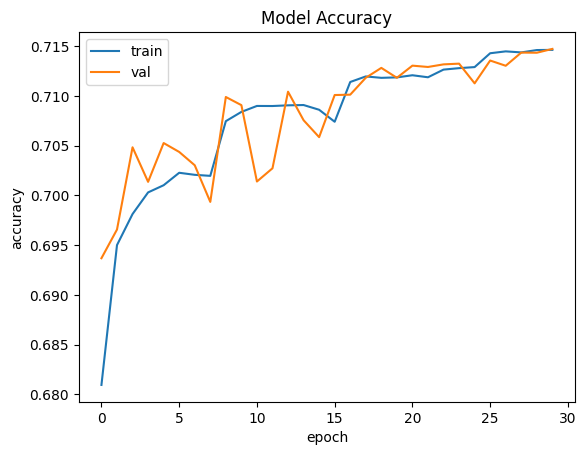

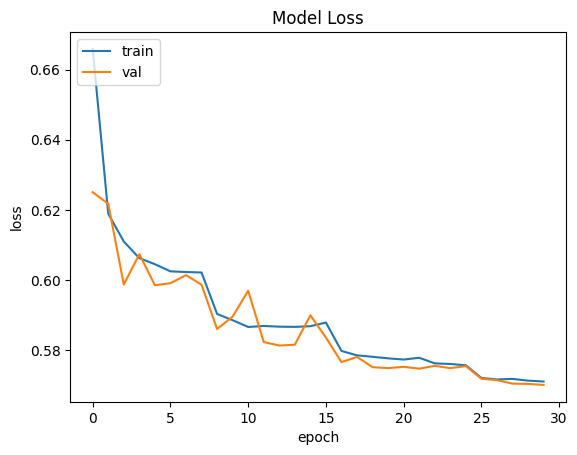

In [26]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
#Test predictions
prediction = model.predict(X_tst)

27415/27415 [==============================] - 59s 2ms/step


In [28]:
#pred = [1 if prediction[i] >= 0.5 else 0 for i in range(len(prediction))]
pred = [np.argmax(x) for x in prediction]
pd.Series(pred).value_counts()

9     142657
7     133222
1     103127
5     102501
2      82997
4      82662
3      80339
8      79261
0      31393
6      22895
10     16196
dtype: int64

In [30]:
print(classification_report(y_test.to_numpy(), pred, digits=6))

              precision    recall  f1-score   support

           0   0.679706  0.267561  0.383974     79750
           1   0.488883  0.632188  0.551376     79750
           2   0.911129  0.948226  0.929307     79750
           3   0.991362  0.998683  0.995009     79750
           4   0.949856  0.984539  0.966887     79750
           5   0.649789  0.835160  0.730904     79750
           6   0.510504  0.146558  0.227736     79750
           7   0.598032  0.999009  0.748183     79750
           8   0.998309  0.992188  0.995239     79750
           9   0.483460  0.864815  0.620205     79750
          10   0.956532  0.194257  0.322932     79750

    accuracy                       0.714835    877250
   macro avg   0.747051  0.714835  0.679250    877250
weighted avg   0.747051  0.714835  0.679250    877250



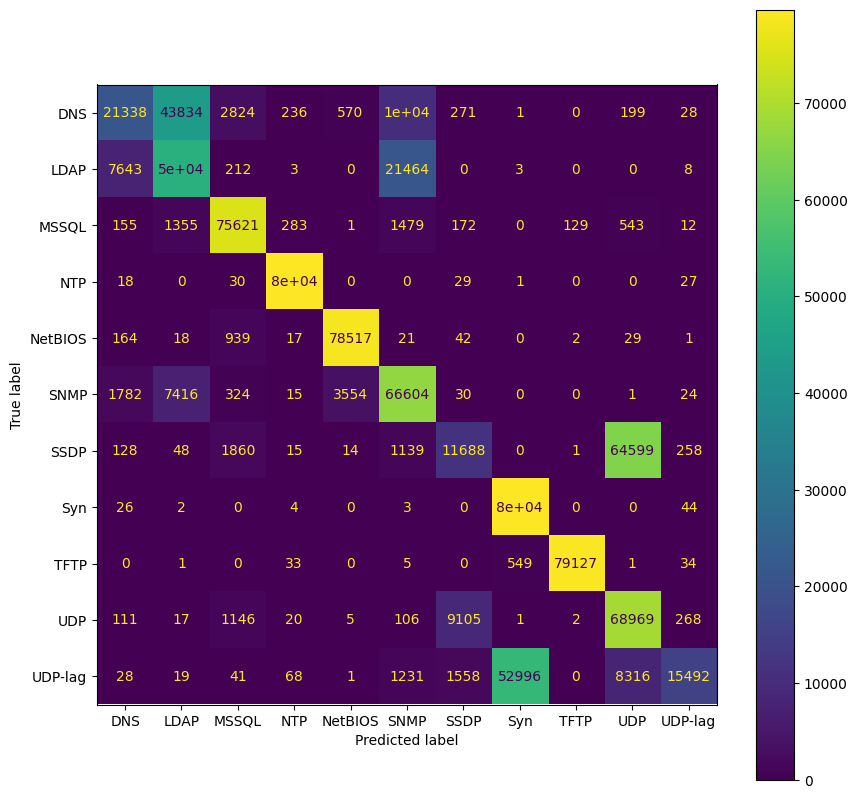

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=multiclass_labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
plt.savefig("confusion_big.png")